# inspect single model


In [16]:
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
schargs = {
   'concentration':7.558,
   'stickiness_wi':6.1029,
   'stickiness_bt':12.2224,
   'sparsity':0.0439,
   'pvar': 0,
   'lrate':1,
   'lratep':1,
   'decay_rate':1,
}
semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}


In [18]:
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_7.558-stickiness_wi_6.103-stickiness_bt_12.222-sparsity_0.044-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [19]:
## timestamp and dir for saving
import os
tstamp = time.perf_counter_ns()
figdir = 'figures/single_model_nb/%s-%i/'%(param_str,tstamp)
os.makedirs(figdir)

### main

In [25]:
ns = 100
L = []
condL = ['blocked','interleaved',
         'early','middle','late'
        ]
exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr,seeds,{data}]


In [30]:
## accuracy
# bads = get_bad_seed(exp_batch_data,max_splits=50)
# goods = np.setdiff1d(np.arange(ns),bads)
batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
mean_acc = batch_acc.mean(1)
test_acc = mean_acc[:,-40:].mean(1) # curr  
test_acc

array([0.98187168, 0.60913438, 0.981872  , 0.63538251, 0.6270971 ])

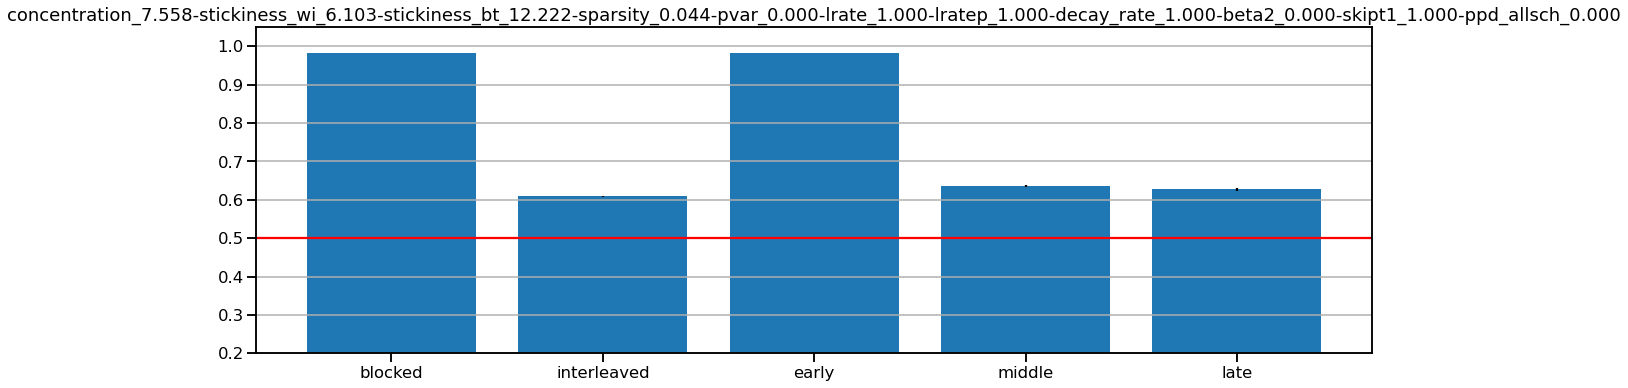

In [31]:
plt.figure(figsize=(20,6))
M = mean_acc[:,-40:].mean(1)
S = mean_acc[:,-40:].std(1)/np.sqrt(ns)
plt.bar(condL,test_acc,yerr=S)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'Mtestacc.png')

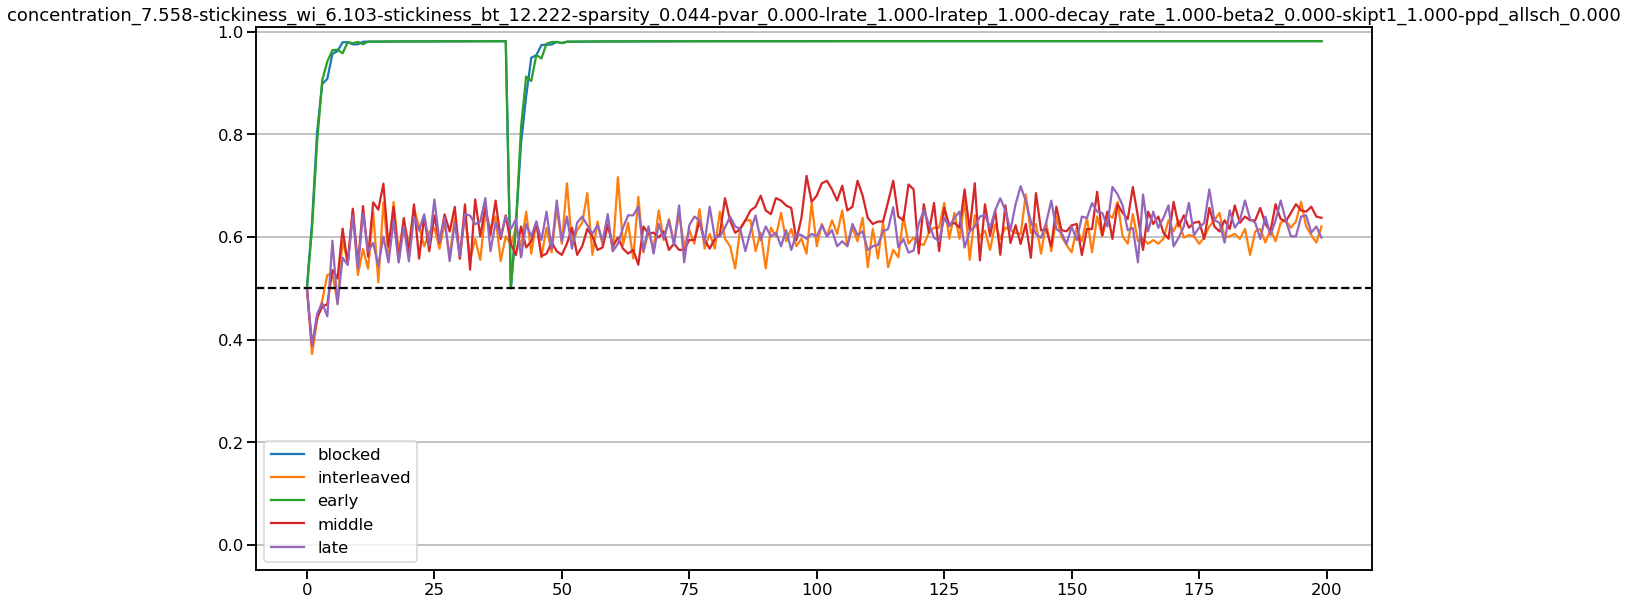

In [33]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.axhline(0.5,c='k',ls='--')
plt.ylim(-0.05,1.01)
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'acc-by-time.png')


# analysis of model state

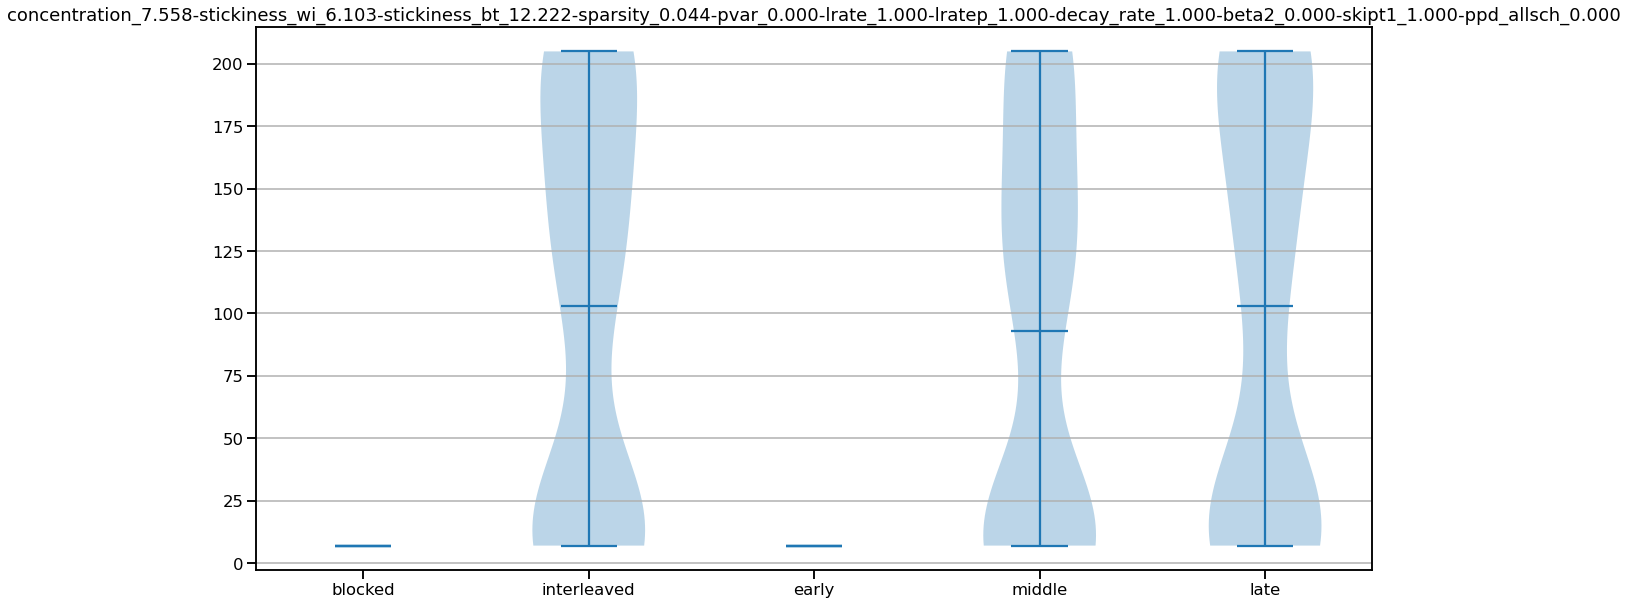

In [34]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(len(condL)):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(exp_batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(20,10))
plt.title('number schemas used')
plt.violinplot(nschemas.T,np.arange(len(condL)),showmeans=True)
# plt.bar(condL,M,zorder=-100,alpha=0.1)
ax = plt.gca()
ax.set_xticks(range(len(condL)))
ax.set_xticklabels(condL)
plt.grid(True,axis='y')
plt.title(param_str)
plt.savefig(figdir+'nsch-violin.png')

In [35]:
curr_idx = 0
seed_idx = 1
## 
prior = unpack_data(exp_batch_data,
        dtype='prior')[curr_idx][seed_idx]
like = unpack_data(exp_batch_data,
        dtype='like')[curr_idx][seed_idx]
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][seed_idx]
post.shape

(200, 5, 7)

### infered schema

In [36]:
curr = 0
for seed in range(20):
  print('seed',seed)
  zt = exp_batch_data[curr][seed]['zt']
  st = exp_batch_data[curr][seed]['exp']

  prior = unpack_data(exp_batch_data,
          dtype='prior')[curr][seed] # trial,tstep,sch
  like = unpack_data(exp_batch_data,
          dtype='like')[curr][seed]
  post = unpack_data(exp_batch_data,
          dtype='post')[curr][seed]
  xth = exp_batch_data[curr][seed]['xth'].argmax(-1)


  for i in np.arange(83):
#   for i in np.arange(100):
#   for i in np.arange(5):
    
    print("t%.2i"%i,'z_h=',zt[i],'st=',st[i],'xth=',xth[i]
  #        post[i,:,1],
  #        post[i,:,2]
         )

seed 0
t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 7 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 0 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 7 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 0 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 8 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 0 0 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 7 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 0 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 8 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 7 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 0 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 8 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 0 0 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 0 8 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 0 7 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

t00 z_h= [ 0. -1.  1.  2. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t02 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t03 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t04 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t05 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 0 7 0]
t07 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t08 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t11 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 2. -1.  2.  2. -1.] st= [0 1 

# posterior, likelihood, prior

In [37]:
def plt_prdata(dtype='post',schL=[0,1],curr_idx=0,seed_idx=0):
  """ 
  plots probability data (post,prior,like) 
  of at most 3 timesteps of 4 schemas
  NB single seed
  """
  # load data
  prdata = unpack_data(exp_batch_data,
          dtype=dtype)[curr_idx][seed_idx]
  # setup plots
  f,axar = plt.subplots(3,4,figsize=(20,10),sharex=True,sharey=True)
  # loop over timesteps and schema
  for ti,tstep in enumerate([0,2,3]):
    for si,sch in enumerate(schL):
      axar[0,si].set_title('sch%i'%sch)
      ax = axar[ti,si]
      # plot
      ax.plot(prdata[:,tstep,sch])
      for k in np.arange(0,200,40):
        ax.axvline(k,c='k',lw=0.5)
    axar[ti,0].set_ylabel('tstep%i'%tstep)
  title = '%s-%s'%(dtype,param_str)
  plt.suptitle(title)
  plt.savefig(figdir+'%s.png'%dtype)



15


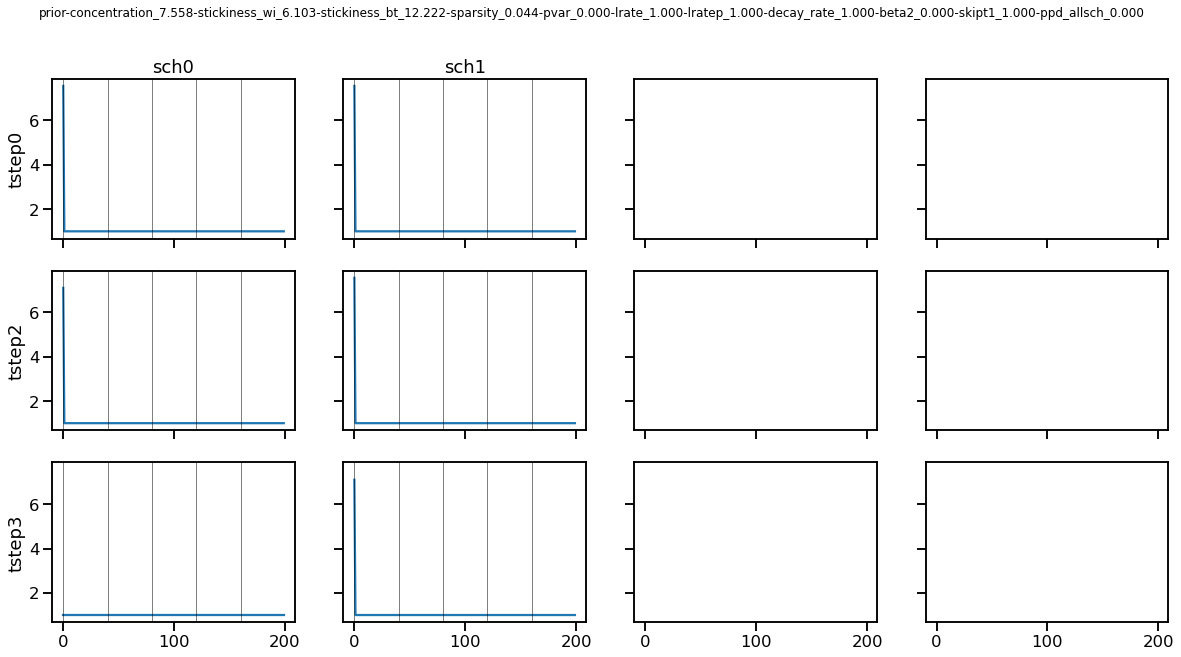

In [38]:
curr_idx=1
seed_idx=0
nsch = len(np.unique(exp_batch_data[curr_idx][seed_idx]['zt']))-1
print(nsch)
schL = [0,1]
plt_prdata('prior',schL,curr_idx,seed_idx)

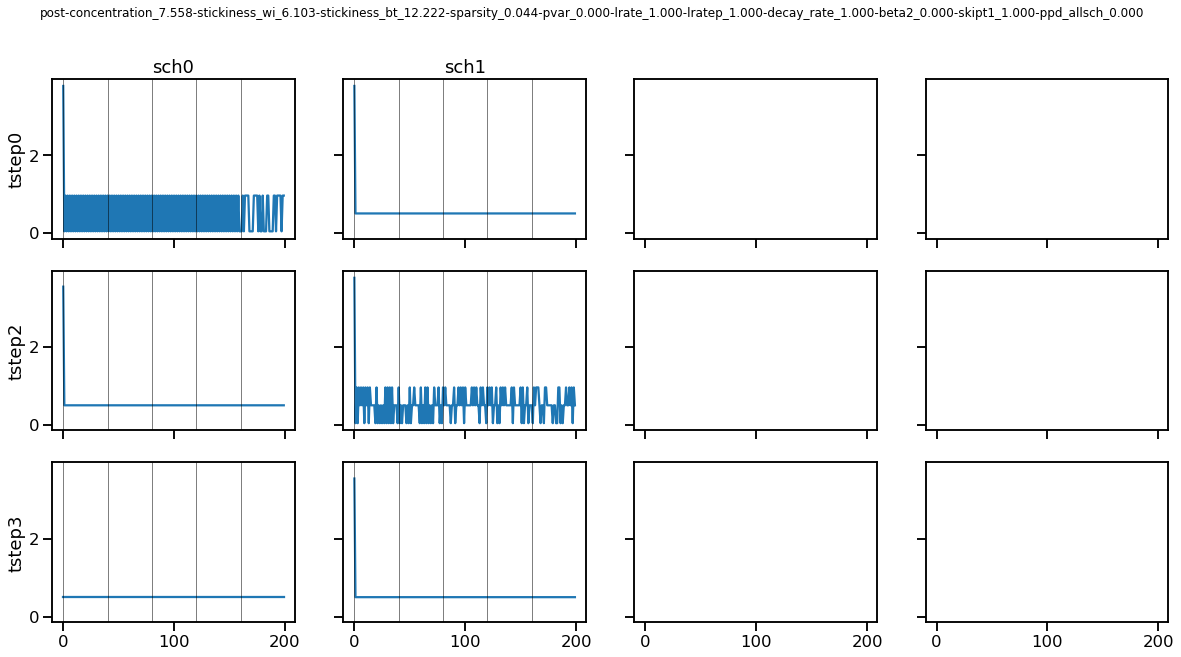

In [39]:
plt_prdata('post',schL,curr_idx,seed_idx)

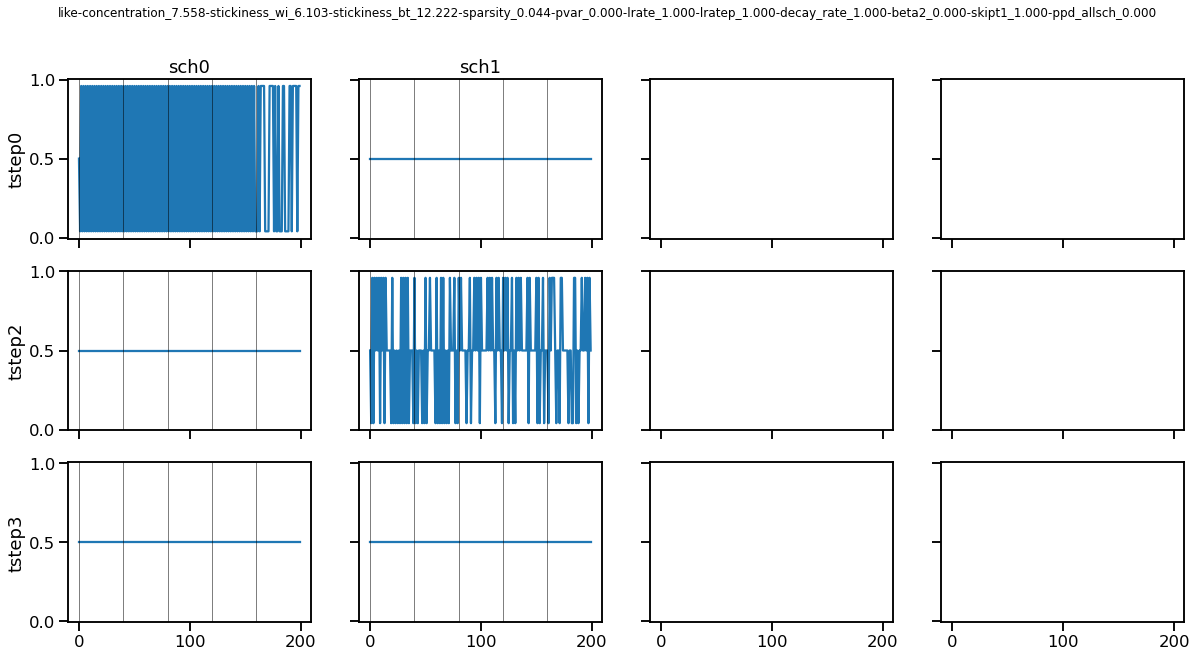

In [40]:
plt_prdata('like',schL,curr_idx,seed_idx)

In [41]:
def get_bad_seed(exp_batch_data,max_splits=10):
  bad_seed_L = []
  for curr_idx in range(5):
    for seed_idx in range(ns):
      max_sch = np.max(exp_batch_data[curr_idx][seed_idx]['zt'])
      if max_sch>max_splits:
        bad_seed_L.append(seed_idx)
  return list(set(bad_seed_L))
# get_bad_seed(exp_batch_data,max_splits=10)

### adjusted rand score

In [42]:
def calc_adjrand(exp_batch_data):
  arscores = -np.ones([len(condL),ns,3])
  for curr_idx in range(len(condL)):
    for seed_idx in range(ns):
      for t_idx,tstep in enumerate([0,2,3]):
        arscores[curr_idx,seed_idx,t_idx] = adjusted_rand_score(
          exp_batch_data[curr_idx][seed_idx]['exp'][:,1],
          exp_batch_data[curr_idx][seed_idx]['zt'][:,tstep]
        )
  return arscores

arscores = calc_adjrand(exp_batch_data)

In [ ]:
f,axar=plt.subplots(1,3,figsize=(30,6),sharey=True)
for t in range(3):
  ax=axar[t]
  ax.violinplot(arscores[:,:,t].T,showextrema=1,showmeans=1)
  for c in range(len(condL)):
    ax.scatter(np.repeat(c+1,ns),arscores[c,:,t].T)
  ax.set_xticks(np.arange(1,len(condL)+1))
  ax.set_xticklabels(condL)
  ax.set_title(['0','2','3'][t])
plt.suptitle(param_str)
plt.savefig(figdir+'adjrand')

# inspect splitting

In [ ]:
curr_idx,seed_idx=0,5
print('zt\n',exp_batch_data[curr_idx][seed_idx]['zt'][:3])
for k in ['post','prior','like']:
  print(k)
  print(exp_batch_data[curr_idx][seed_idx][k][:2,:,:5])
exp_batch_data[curr_idx][seed_idx][k].shape

# inspect prediction

In [ ]:
curr_idx,seed_idx=1,1
exp_batch_data[curr_idx][seed_idx]['xth'].argmax(-1)


In [ ]:
curr_idx,seed_idx=0,5
print('zt\n',exp_batch_data[curr_idx][seed_idx]['zt'][:3])
for k in ['xth']:
  print(k)
  print(exp_batch_data[curr_idx][seed_idx][k][:2,:,:5])
exp_batch_data[curr_idx][seed_idx][k].shape